In [1]:
%load_ext autoreload
%autoreload 2

# PriorVAE reimplementation

For a 1D GP

In [10]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(3)

In [11]:
from reusable.kernels import esq_kernel

args = {
    # GP prior configuration
    "n": 100,
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}
args.update({ # so we can use the definition of n to define x
    
    "x": jnp.arange(0, 1, 1/args["n"]),

    # VAE configuration
    "hidden_dim1": 35,
    "hidden_dim2": 32,
    "latent_dim": 30,
    "vae_var": 0.1,

    # learning
    "num_epochs": 50,
    "learning_rate": 1.0e-3,
    "batch_size": 500,
    "train_num_batches": 500,
    "test_num_batches": 1,

    # MCMC parameters
    "num_warmup": 1000,
    "num_samples": 1000,
    "thinning": 1,
    "num_chains": 3,

    "pretrained_vae": False


})

rng_key, _ = random.split(random.PRNGKey(4))

### Examples of priors to encode

## SVI to learn VAE parameters

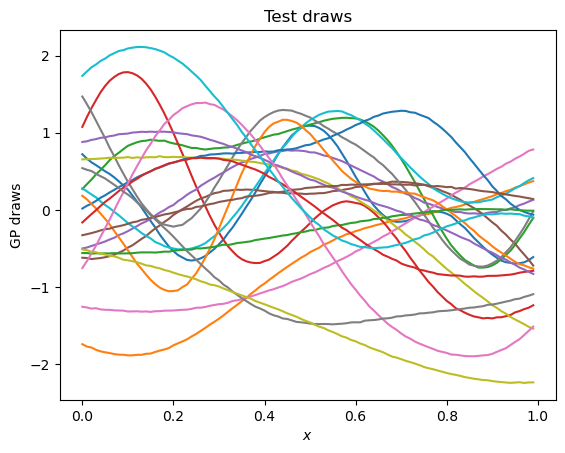

In [12]:
if not args["pretrained_vae"]:
    from reusable.gp import OneDGP
    from reusable.data import gen_gp_batches
    
    rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
    
    train_draws = gen_gp_batches(args["x"], OneDGP, args["gp_kernel"], args["train_num_batches"], args["batch_size"], rng_key_train)
    test_draws = gen_gp_batches(args["x"], OneDGP, args["gp_kernel"], 1, args["test_num_batches"]* args["batch_size"], rng_key_test)
    
    from plotting.plots import plot_draws

    plot_draws(train_draws[4], args["x"], "Test draws", "GP draws")




In [13]:
from reusable.vae import VAE
from reusable.train_nn import SimpleTrainState
import optax

rng_key, rng_key_init, rng_key_train = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=False,
)
params = module.init(rng_key, jnp.ones((args["n"],)))["params"]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key = rng_key_init)


epoch: 1, {'train_loss': Array(0.00198749, dtype=float32), 'train_avg_loss': Array(0.0698496, dtype=float32), 'test_loss': Array(0.00198748, dtype=float32)}
epoch: 6, {'train_loss': Array(0.00395979, dtype=float32), 'train_avg_loss': Array(0.1365494, dtype=float32), 'test_loss': Array(0.00395979, dtype=float32)}
epoch: 11, {'train_loss': Array(0.00160704, dtype=float32), 'train_avg_loss': Array(0.06561742, dtype=float32), 'test_loss': Array(0.00160704, dtype=float32)}
epoch: 16, {'train_loss': Array(0.00335982, dtype=float32), 'train_avg_loss': Array(0.03802564, dtype=float32), 'test_loss': Array(0.00335982, dtype=float32)}
epoch: 21, {'train_loss': Array(0.00019226, dtype=float32), 'train_avg_loss': Array(0.03481451, dtype=float32), 'test_loss': Array(0.00019226, dtype=float32)}
epoch: 26, {'train_loss': Array(0.00139659, dtype=float32), 'train_avg_loss': Array(0.1583293, dtype=float32), 'test_loss': Array(0.00139659, dtype=float32)}
epoch: 31, {'train_loss': Array(0.00939469, dtype=f

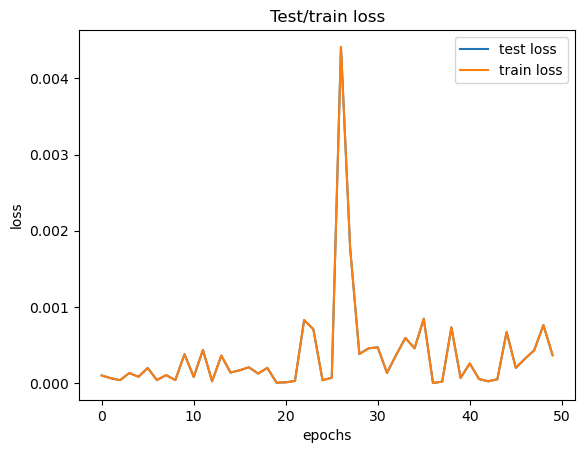

In [15]:
import optax
import jax

from reusable.train_nn import SimpleTrainState
from plotting.plots import plot_training

from reusable.loss import combo_loss, RCL, KLD



def compute_epoch_metrics(final_state: SimpleTrainState, train_output, test_output):
    return {}

if not args["pretrained_vae"]:
    from reusable.train_nn import run_training

    state, metrics_history = run_training(
            combo_loss(RCL, KLD), compute_epoch_metrics, args["num_epochs"], train_draws, test_draws[0], state
        )

    print(metrics_history)

    plot_training(metrics_history["test_loss"]/args["batch_size"], metrics_history["train_loss"]/(args["batch_size"] * args["test_num_batches"]), "Test/train loss", note="loss")


### Training progress

comment 09/02/2023: why is there a shelf in the loss?, also, why is our test loss so closer to train loss?

In [8]:
from flax.core.frozen_dict import freeze
from reusable.util import decoder_filename, get_savepath

file_path = f'{get_savepath()}/{decoder_filename("02", args)}'

if not args["pretrained_vae"]:
    decoder_params = freeze({"params": state.params["VAE_Decoder_0"]})
    args["decoder_params"] = decoder_params
    with open(file_path, 'wb') as file:
       file.write(serialization.to_bytes(decoder_params))

if args["pretrained_vae"]:
    from reusable.vae import VAE_Decoder
    dummy_decoder = VAE_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"], conditional=False)
    dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))
    with open(file_path, 'rb') as file:
        bytes = file.read()
        
        args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

## Demonstrations

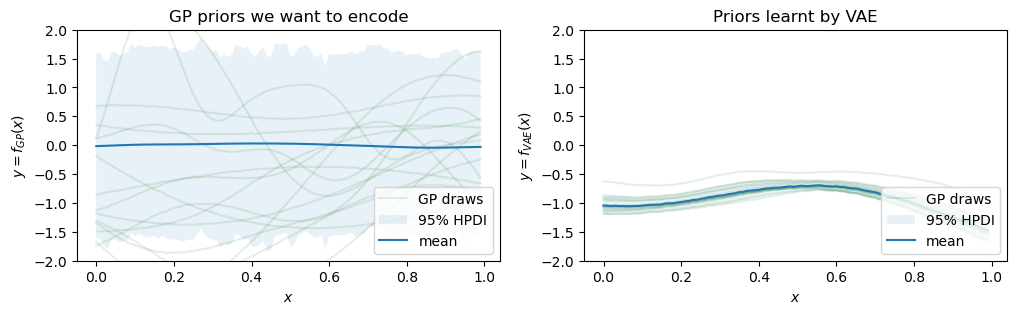

In [9]:
from reusable.vae import vae_sample
from plotting.plots import compare_draws
from reusable.gp import OneDGP
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = plot_vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]

compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by VAE", '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$', save_path="gen_plots/01_prior_comp.png")


# Inference

In [ ]:
import os


def run_mcmc(rng_key, model_mcmc, y_obs, obs_idx, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(
        rng_key,
        args["hidden_dim1"],
        args["hidden_dim2"],
        args["latent_dim"],
        args["n"],
        args["decoder_params"],
        y=y_obs,
        obs_idx=obs_idx,
    )
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()


In [ ]:
from reusable.vae import vae_mcmc

rng_key_ground_truth = random.PRNGKey(
    1
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(OneDGP, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], noise=True
)
ground_truth = gt_draws["f"].T
ground_truth_y_draw = gt_draws["y"].T


x_obs_lst = []
y_obs_lst = []
predictions_lst = []

obs_idx_lst = [[22, 50], [16, 33, 57, 96], [8, 24, 45, 61, 77, 84]]



rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

for i in range(len(obs_idx_lst)):
    obs_idx = jnp.array(obs_idx_lst[i])

    y_obs = ground_truth_y_draw[obs_idx, 0]
    x_obs = args["x"][obs_idx]


    # inference
    mcmc_samples = run_mcmc(rng_key_post, vae_mcmc, y_obs, obs_idx)
    # hidden_dim1, hidden_dim2, latent_dim, out_dim, decoder_params
    predictive = Predictive(vae_mcmc, mcmc_samples)
    predictions = predictive(
        rng_key_pred,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
    )["f"]

    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    obs_idx_lst.append(obs_idx)
    predictions_lst.append(predictions)





  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 4.357573986053467


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 4.248981237411499


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 4.954373359680176


In [ ]:
prior_predictive = Predictive(vae_sample, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior,  hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"])["f"]



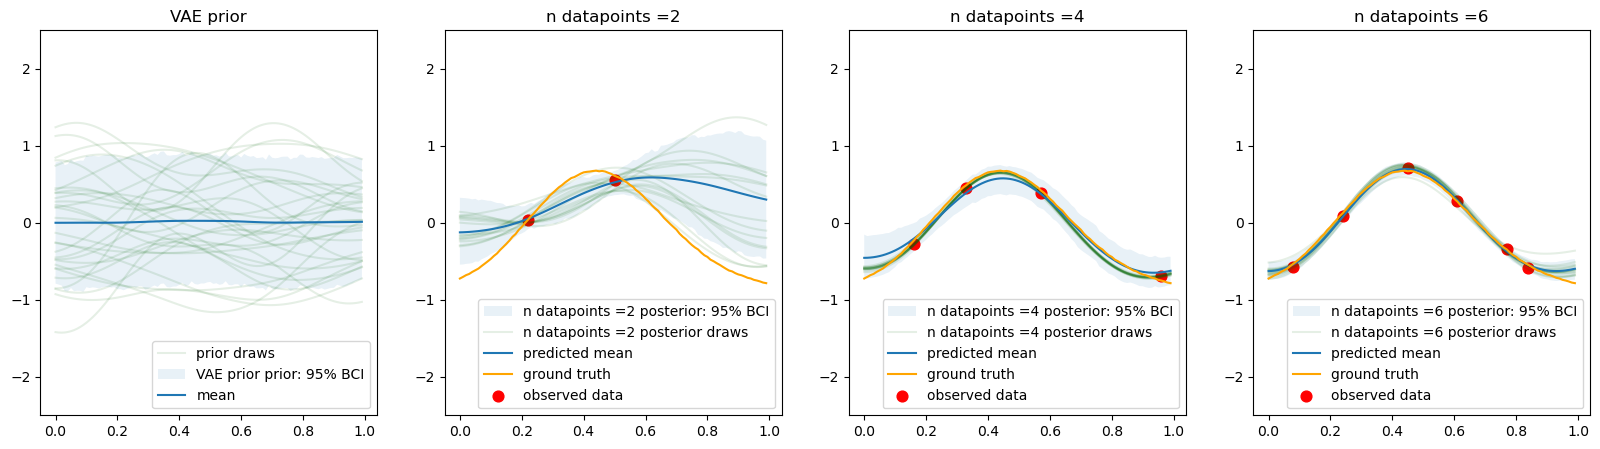

In [ ]:
from plotting.plots import compare_inference_steps


compare_inference_steps(args["x"], ground_truth, x_obs_lst, y_obs_lst, prior_predictions, predictions_lst, title="VAE", save_path="gen_plots/02_inference_steps.png")

## Covariance matrices

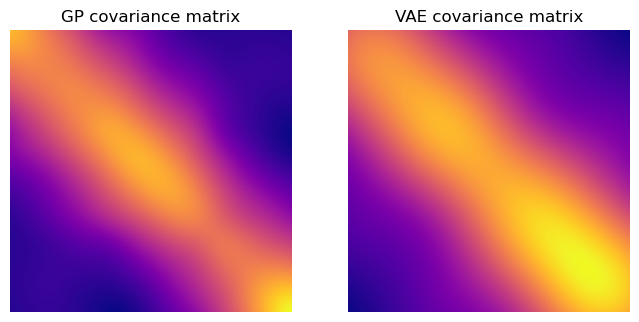

In [ ]:
from plotting.plots import plot_cov_mat
import matplotlib.pyplot as plt

rng_key, rng_key_predict = random.split(random.PRNGKey(6))

gp_predictive = Predictive(OneDGP, num_samples=100)
gp_draws = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']
gp_draws = gp_draws[~jnp.isnan(gp_draws).any(axis=1), :]

vae_predictive = Predictive(vae_sample, num_samples=100)

vae_draws = vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]
#vae_draws[~np.isnan(gp_draws).any(axis=1), :]



fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))

plot_cov_mat(gp_draws, "GP covariance matrix", axs[0])
plot_cov_mat(vae_draws, "VAE covariance matrix", axs[1])


